<a href="https://colab.research.google.com/github/JSunOO/OPENCVPROJECT/blob/main/Segmentaition_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

In [ ]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
"""
1. 위 패키지에서 데이터셋을 다운받는다.
2. 전처리함수를 정의한다.
3. 데이터셋에 전처리 함수를 적용시킨다.
4. 특정 이미지를 불러와서 Segmentation 이 잘 되었을 때 픽셀의 클래스가 어떻게 분류될지 확인한다.
"""

'\n1. 위 패키지에서 데이터셋을 다운받는다.\n2. 전처리함수를 정의한다.\n3. 데이터셋에 전처리 함수를 적용시킨다.\n4. 특정 이미지를 불러와서 Segmentation 이 잘 되었을 때 픽셀의 클래스가 어떻게 분류될지 확인한다.\n'

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def normalize(input_image, input_mask):
    """
    이미지를 정규화한다.
    각 픽셀값을 최댓값인 255로 나누어준다.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [ ]:
def load_image_train(datapoint):
    """
    훈련 데이터셋에 해당하는 이미지와 레이블을 불러온온다.
    불러오는 과정에서 사이즈를 조정하고 이미지 증강에 해당하는 정규화를 적용시킨다.
    """
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
    """
    시험 데이터셋에 해당하는 이미지와 레이블을 불러온온다.
    불러오는 과정에서 사이즈를 조정하고 정규화를 적용시킨다.
    """
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
    """
    데이터셋에 전처리함수를 적용시킨다.
    """
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
     
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
     
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
    """
    입력 이미지와 타겟 레이블, 예측 레이블의 결과를 시각화한다.
    """
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

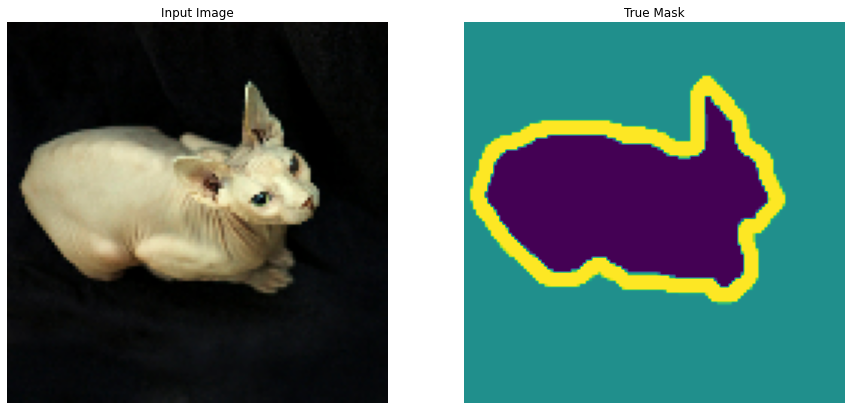

In [ ]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask

display([sample_image, sample_mask])

In [ ]:
"""
아래는 분할 담당 모델을 직접 구현하지는 않고 기존 모델의 구조 일부분을 빌린다.
MobileNetV2의 일부 층을 활용하여 Downsampling 하고,
Keras의의 Pix2Pix를 활용하여 Upsampling 하는 모델을 만든다.
""" 

In [ ]:
OUTPUT_CHANNELS = 3
"""
MobileNetV2를 활용하여 Downsampling 을 담당하는 코드드
"""
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]


down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False


In [ ]:
"""
Upsampling 을 담당하는 코드드
"""
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
    """
    모델을 정의한다.
    위에서 정의했던 Downsampling/Upsampling 부분을 불러온 뒤에 이미지 크기를 맞추기위해 마지막 층을 추가한다.
    """
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling을 진행하는 부분
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling을 진행하는 부분
    for up, skip in zip(up_stack, skips):
        x = up(x)
        # Downsampling 결과를 Concatenate 해준다.
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # 출력되는 이미지 크기를 동일하게 하기 위해 마지막 층을 구현한한다.
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)
     

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           [(None, 64, 64, 96)  1841984     ['input_4[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

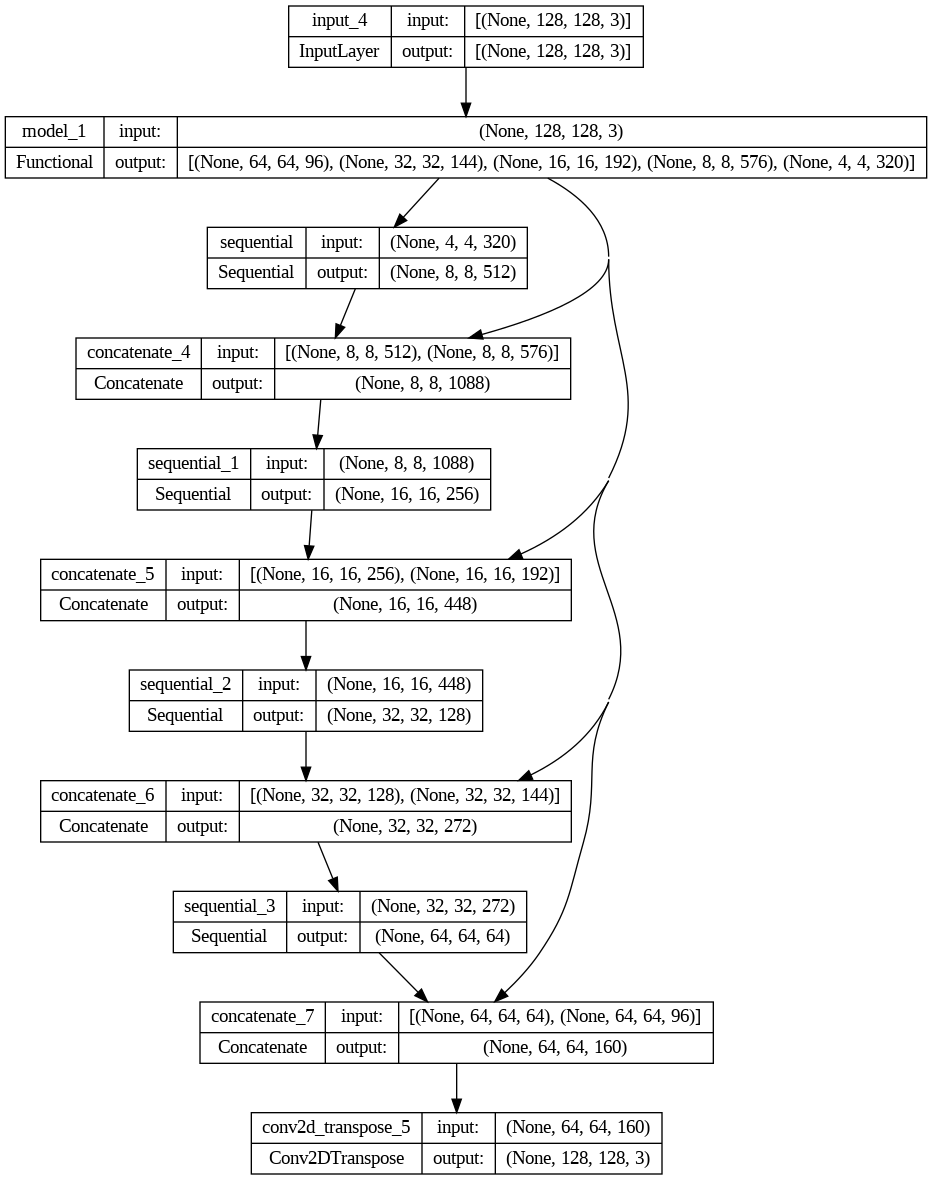

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
"""
모델의 예측을 보여주는 함수와 학습 도중 해당 함수를 동작시키게 하는 Callback을 정의한다.
"""

In [ ]:
def create_mask(pred_mask):
    """
    예측 시 픽셀의 레이블을 확정하는 함수
    """
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    예측한 레이블을 시각화하는 함수
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 1s/step


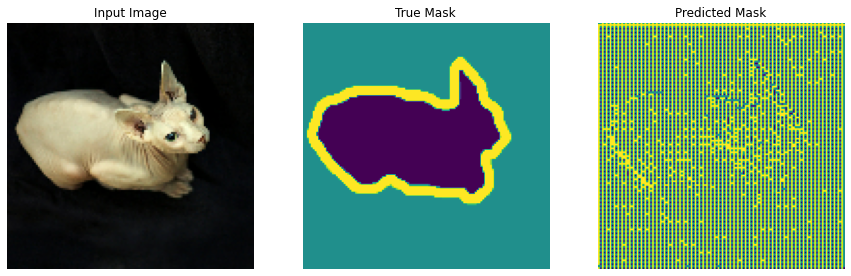

In [ ]:
show_predictions()